In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
# load paths 
TRAIN_IMG_PATH = "./data/train_images.npy"
TRAIN_LAB_PATH = "./data/train_labels.csv"

In [3]:
images = np.load(TRAIN_IMG_PATH, encoding='bytes')
images.shape

labels = pd.read_csv(TRAIN_LAB_PATH)

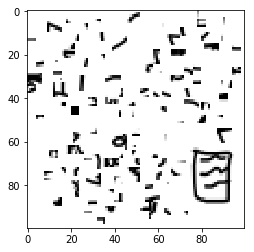

In [31]:
tmpImg = images[952][1].reshape((100,100)).astype(np.uint8)
plt.imshow(tmpImg, cmap='gray_r')
plt.show()

In [5]:
# Try to find contours
from skimage import measure
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


def getLongestContour(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    img_contours.sort(key=lambda x: len(x), reverse=True)
    return img_contours[0]

# need to wrap with try / except, for when contour is invalid 
def tryPolygonArea(contour):
    try:
        return Polygon(contour).area
    except:
        return 0

def getLargestContour(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    img_contours.sort(key=tryPolygonArea, reverse=True)
    return img_contours[0]
    

def overlayContour(img, contour):
    plt.imshow(img, cmap='gray_r')
    # Plot the longest contour
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.show()

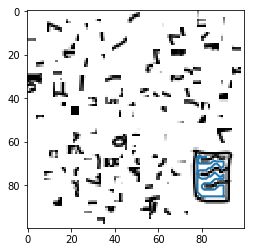

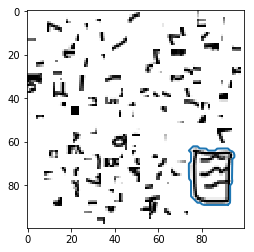

In [32]:
tmpImg = images[952][1].reshape((100,100)).astype(np.uint8)

longest_contour = getLongestContour(tmpImg)
overlayContour(tmpImg, longest_contour)
largest_contout = getLargestContour(tmpImg)
overlayContour(tmpImg, largest_contout)

# Using contours to find noise

There are two methods to find an image in noise. The first is by looking at the contour length. The second is by looking at the contour area. We can see that there often is only one or two contours with significantly greater size:

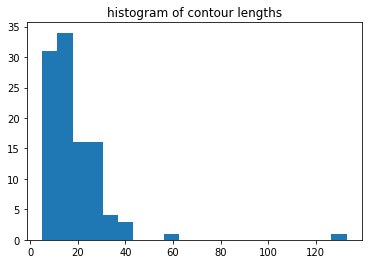

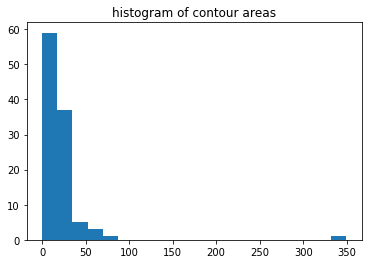

In [124]:
# histogram of contours to find potentially noise

def plotContourLengths(contours):
    contour_lengths = np.zeros(len(contours))
    for i, contour in enumerate(contours):
        contour_lengths[i] += float(len(contour))

    plt.hist(contour_lengths, bins=20)
    plt.title('histogram of contour lengths')
    plt.show()
    
def plotContourAreas(contours):
    contour_areas = np.zeros(len(contours))
    for i, contour in enumerate(contours):
        try:
            contour_areas[i] += float(Polygon(contour).area)
        except:
            contour_areas[i] += 0

    plt.hist(contour_areas, bins=20)
    plt.title('histogram of contour areas')
    plt.show()


def findAndPlotContourLengths(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    plotContourLengths(img_contours)
    
def findAndPlotContourAreas(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    plotContourAreas(img_contours)
    
findAndPlotContourLengths(tmpImg)
findAndPlotContourAreas(tmpImg)

# Trends of Contours in Noise-only (empty) images versus Non-noise-only (not empty) images

We can detect noise-only images by looking at the size of either of these metrics:

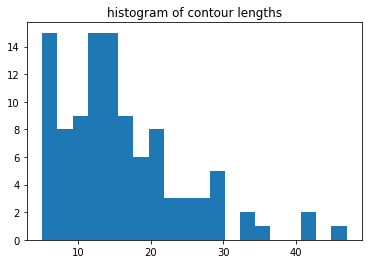

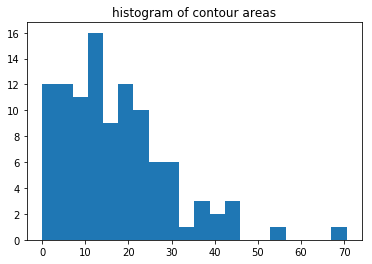

In [125]:
empty_img = images[97][1].reshape((100,100)).astype(np.uint8)
findAndPlotContourLengths(empty_img)
findAndPlotContourAreas(empty_img)

### Histogram of area and length of largest contours in all noise-only images in test set

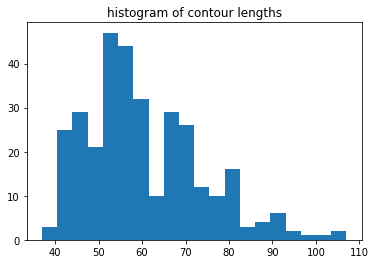

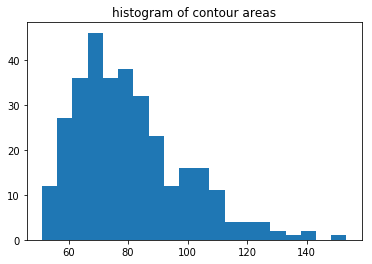

In [133]:
noise_only_images = labels[labels['Category'].isin({'empty'})]
NoiseLongestContours = []
NoiseLargestContours = []

for ID in noise_only_images['Id']:
    noiseImg = images[ID][1].reshape((100,100)).astype(np.uint8)
    NoiseLongestContours.append(getLongestContour(noiseImg))
    NoiseLargestContours.append(getLargestContour(noiseImg))

plotContourLengths(NoiseLongestContours)
plotContourAreas(NoiseLargestContours)

### Histogram of area and length of *non-noise* images in test-set

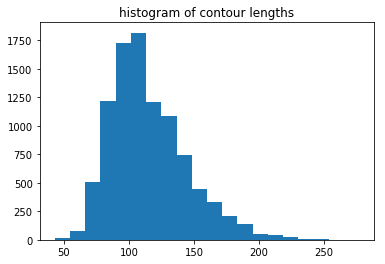

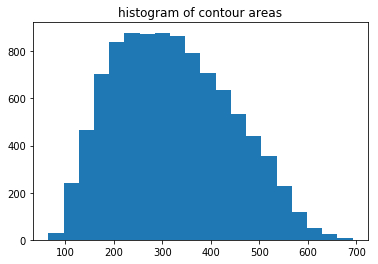

In [134]:
not_noise_images = labels[~labels['Category'].isin({'empty'})]
notNoiseLongestContours = []
notNoiseLargestContours = []
for ID in not_noise_images['Id']:
    notNoiseImg = images[ID][1].reshape((100,100)).astype(np.uint8)
    notNoiseLongestContours.append(getLongestContour(notNoiseImg))
    notNoiseLargestContours.append(getLargestContour(notNoiseImg))
plotContourLengths(notNoiseLongestContours)
plotContourAreas(notNoiseLargestContours)

## Conclusions from the above data

The majority of the largest contour areas for noise-only images lie between 60 and 100, whereas the majority of the largest contour areas for non-noise images are larger than 100. This means that it is relatively safe to assume that the largest contour is of the drawing, and not of some other noise.

# A potential route: use Naive Filter to remove noise

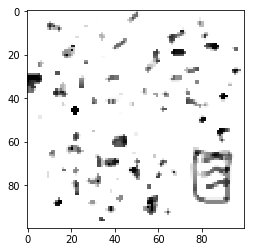

In [68]:
# Use some sort of naive filter (deprecated)
from skimage import filters

med_filter_tmpImg = filters.median(tmpImg, np.ones((3, 3)))

plt.imshow(med_filter_tmpImg, cmap='gray_r')

plt.show()

# Remove noise via Raycast on contour

There are two ways we can select which contour to use:

1. The contour that is longest (largest surface area)
2. The contour that has the largest area

The function below allows for either case. Either put down `contour_type='longest'` for (1), or `contour_type=largest` for (2)

In [12]:
def removeNoiseViaContour(oldImg, contour_type='longest'):
    if contour_type == 'longest':
        contour = getLongestContour(oldImg)
    elif contour_type == 'largest':
        contour = getLargestContour(oldImg)
    else:
        print("Invalid contour_type:", contour_type, ". Allowed values: longest, largest")
        raise
    polygon = Polygon(contour)
    #set to 0
    newImg = [[0 for j in range(len(oldImg[i]))] for i in range(len(oldImg))]
    #iterate through old image
    for i in range(len(oldImg)):
        for j in range(len(oldImg[i])):
            point = Point(i,j)
            if polygon.contains(point):
                newImg[i][j] = oldImg[i][j]
    return newImg

## How to choose which method?

It seems like the second method is better than the first. This is because the longest contour may in fact be inside of the image, and so none of the lines of the image are actually inside of the first polygon. In the other case, however, we choose the contour with the largest area, which will most likely also surround the image. See the example below for the potential issue with choice (1):

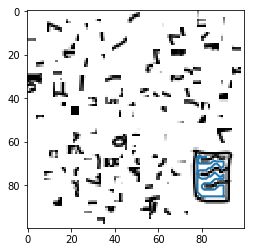

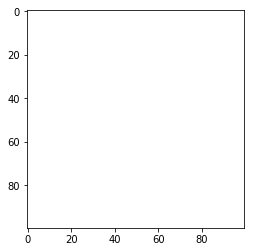

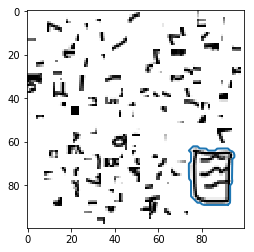

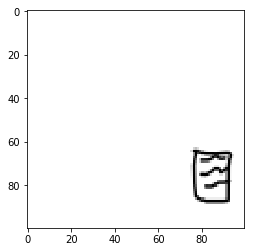

In [73]:
not_noise_img = removeNoiseViaContour(tmpImg)
longest_contour = getLongestContour(tmpImg)
overlayContour(tmpImg, longest_contour)
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

largest_contout = getLargestContour(tmpImg)
overlayContour(tmpImg, largest_contout)
not_noise_img = removeNoiseViaContour(tmpImg, 'largest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

# Remove noise by Raycasting on the bounding box of the contour

This method guarantees that the lines of the image that stay are also inside of the contour. However, this method may also not remove a lot of the noise in the thinner drawings.

In [15]:
# Get the bounding box of the contour
def boundingBoxOfContour(contour):
    minX = float("inf")
    minY = float("inf")
    maxX = -1
    maxY = -1
    for x,y in contour:
        if minX > x:
            minX = x
        if minY > y:
            minY = y
        if maxX < x:
            maxX = x
        if maxY < y:
            maxY = y
    return minX, minY, maxX,maxY

# Removes noise based off of the bounding box of the longest contour. Buffer is how much additional 
# space we want to provide beyond the bounding box.
# If buffer < 1, it will add buffer equal to the (largest side of bounding box * buffer)
def removeNoiseViaBoundingBox(oldImg, buffer = 0, contour_type='longest'):
    if contour_type == 'longest':
        contour = getLongestContour(oldImg)
    elif contour_type == 'largest':
        contour = getLargestContour(oldImg)
    else:
        print("Invalid contour_type:", contour_type, ". Allowed values: longest, largest")
        raise
    minX, minY, maxX, maxY = boundingBoxOfContour(contour)
    
    if (buffer < 1):
        maxLength = max(maxX - minX, maxY - minY)
        buffer = buffer * maxLength
    # overlayContour(oldImg, np.array([[minX, minY], [minX, maxY], [maxX, maxY], [minX, maxY], [minX, minY]]))
    
    newImg = [[0 for j in range(len(oldImg[i]))] for i in range(len(oldImg))]
        
    #iterate through old image
    for x in range(len(oldImg)):
        for y in range(len(oldImg[x])):
            if x >= (minX - buffer) and x <= (maxX + buffer) and y >= (minY - buffer) and y <= (maxY + buffer):
                newImg[x][y] = oldImg[x][y]
    return newImg

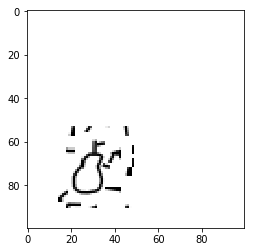

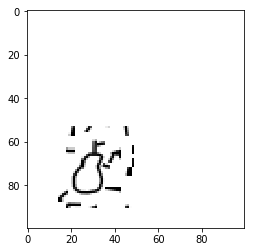

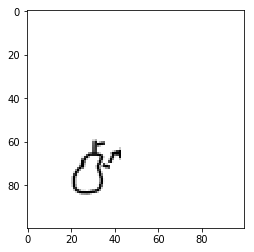

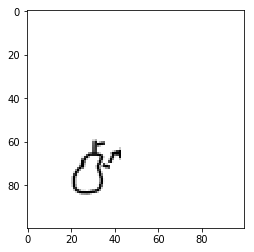

In [74]:
tmpImg = images[78][1].reshape((100,100)).astype(np.uint8)

not_noise_img = removeNoiseViaBoundingBox(tmpImg, .2, 'longest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

not_noise_img = removeNoiseViaBoundingBox(tmpImg, .2, 'largest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

not_noise_img = removeNoiseViaContour(tmpImg, 'longest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

not_noise_img = removeNoiseViaContour(tmpImg, 'largest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

# center, crop, and rescale an image

In [99]:
from scipy.ndimage import zoom

#Finds the first non-zero coordinate, and the last non-zero coordinate.
def boundingBox(img):
    minX = -1
    minY = -1
    maxX = -1
    maxY = -1
    for i, row in enumerate(img):
        nonZeroIndexes = np.nonzero(row)[0]
        if len(nonZeroIndexes) != 0:
            if minX == -1:
                minX = i
            if minY == -1 or minY > np.min(nonZeroIndexes):
                minY = np.min(nonZeroIndexes)
            if maxX < i:
                maxX = i
            if maxY < np.max(nonZeroIndexes):
                maxY = np.max(nonZeroIndexes)
    return (minX, minY), (maxX,maxY)

# Centers the image
def center(img):
    minCoord, maxCoord = boundingBox(img)
    xLength = maxCoord[0] - minCoord[0]
    yLength = maxCoord[1] - minCoord[1]
    newImg = [[0 for j in range(len(img[i]))] for i in range(len(img))]
    
    startX = int((len(img) - xLength) / 2)
    startY = int((len(img[0]) - yLength) / 2)
    for i,x in enumerate(range(startX, startX + xLength + 1)):
        for j,y in enumerate(range(startY, startY + yLength + 1)):
            newImg[x][y] = img[minCoord[0]+i][minCoord[1]+j]
    return newImg

# Crop out all of the white space. If you want square dimensions, then it will pad white space.
def cropWhite(img, isSquare = False):
    minCoord, maxCoord = boundingBox(img)
    xLength = maxCoord[0] - minCoord[0]
    yLength = maxCoord[1] - minCoord[1]
    if isSquare:
        xLength = max(xLength, yLength)
        yLength = max(xLength, yLength)
    
    newImg = [[0 for j in range(yLength + 1)] for i in range(xLength + 1)]
    for i in range(xLength + 1):
        for j in range(yLength + 1):
            # Check for case where we are out of bounds for cropped white + square
            if (minCoord[0] + i) >= len(img) or (minCoord[1] + j) >= len(img[i]):
                newImg[i][j] = 0
            else:
                newImg[i][j] = img[minCoord[0] + i][minCoord[1] + j]
    return newImg

# rescale image to square of height, width = dimension    
def rescale(img, dimension):
    cropped = cropWhite(img)
    height = len(cropped)
    width = len(cropped[0])
    zoomFactor = dimension / max(height, width)
    return zoom(img, zoomFactor, order=0)

### Centered image

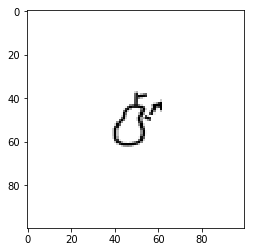

In [94]:
centered_img = center(not_noise_img)
plt.imshow(centered_img, cmap='gray_r')
plt.show()

### Cropped image, without whitespace

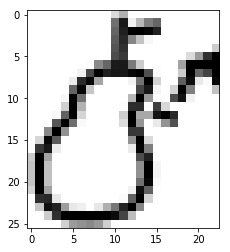

In [95]:
cropped = cropWhite(not_noise_img, False)
plt.imshow(cropped, cmap='gray_r')
plt.show()

### Add whitespace so that the image has square dimensions

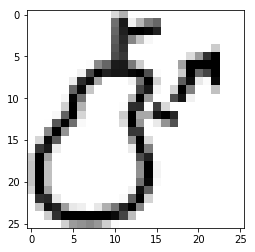

In [96]:
cropped_white = cropWhite(not_noise_img, True)
plt.imshow(cropped_white, cmap='gray_r')
plt.show()

### Rescale the image so that the larger side is 40px

(40, 40)


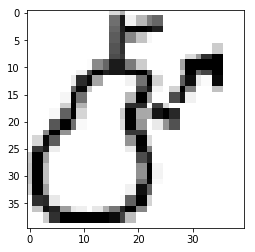

In [100]:
rescaled = rescale(cropped_white, 40)
print(rescaled.shape)
plt.imshow(rescaled, cmap='gray_r')
plt.show()

# Preprocess an image

### Steps:
1. Filter image either by racasting via `bounding_box` or via `contour`. Choose which contour to do bounding-box / raycasting on by stating either contour_type = `longest` or `largest`.
2. Crop image sot that we remove excess whitespace. Make image square.
3. Center image.
4. Rescale image to the `rescaleDimension`

In [25]:
def preprocessImg(img, noiseRemoveType='bounding_box', contour_type='longest', rescaleDimension = 40):
    if noiseRemoveType == 'bounding_box':
        filteredImg = removeNoiseViaBoundingBox(img, .2, contour_type)
    elif noiseRemoveType == 'longest_contour':
        filteredImg = removeNoiseViaContour(img, contour_type)
    else:
        print("Invalid noiseRemoveType:", noiseRemoveType, ". Allowed values: bounding_box, longest_contour")
        raise 
    croppedImg = cropWhite(filteredImg, True)
    centered_img = center(croppedImg)
    rescaled_img = rescale(centered_img, rescaleDimension)
    return rescaled_img

### Test which combination of noiseType and contour work best for a given image.

In [111]:
def testTypesOfPreprocessing(img):
    processedImgs = []
    for noiseType in ['bounding_box', 'longest_contour']:
        for contour in ['longest', 'largest']:
            processed = preprocessImg(img, noiseRemoveType=noiseType, contour_type=contour)
            processedImgs.append({
                'noiseType':noiseType,
                'contour':contour,
                'img':processed
            })
    return processedImgs


# Call this function to run and then display the test results. Include a directory in "saveDirectory" if you want to save the plot.
def displayPreprocessingTestResults(img, title, saveDirectory=None):
    results = testTypesOfPreprocessing(img)
    f, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    f.suptitle(title)
    axarr[0].imshow(img, cmap='gray_r')
    axarr[0].set_title('original')

    for i,result in enumerate(results):
        axarr[i+1].imshow(result['img'], cmap='gray_r')
        sub_title = 'crop (' + result['noiseType'] + ', ' + result['contour'] + ')'
        axarr[i+1].set_title(sub_title)
    plt.show()
    if saveDirectory is not None:
        plt.savefig(saveDirectory + '/' + title + '.png')


#### Example usage of the above function:

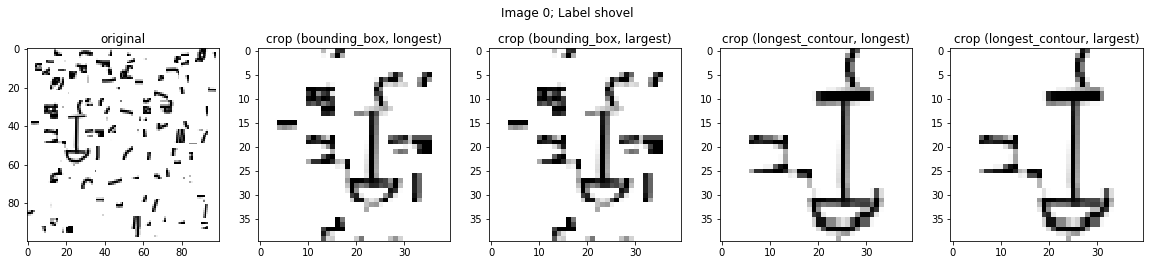

In [108]:
img_0 = images[0][1].reshape((100,100)).astype(np.uint8)
displayPreprocessingTestResults(img_0, 'Image 0; Label '+labels.at[0,'Category'])

In [ ]:
# Run through all 

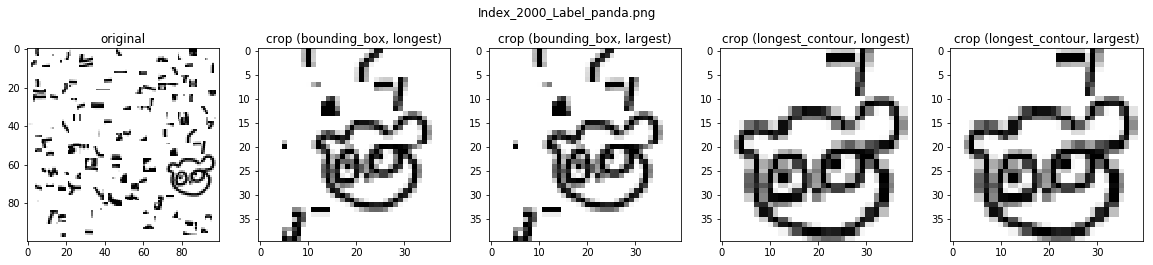

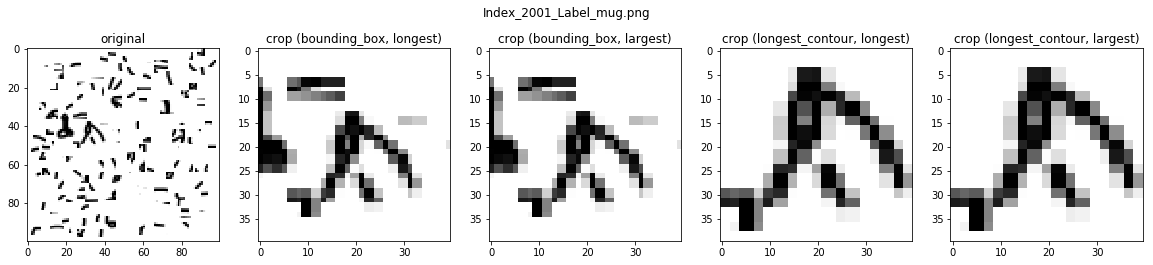

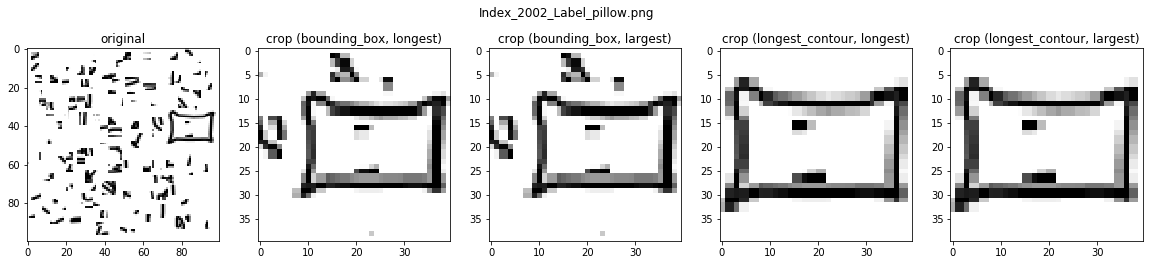

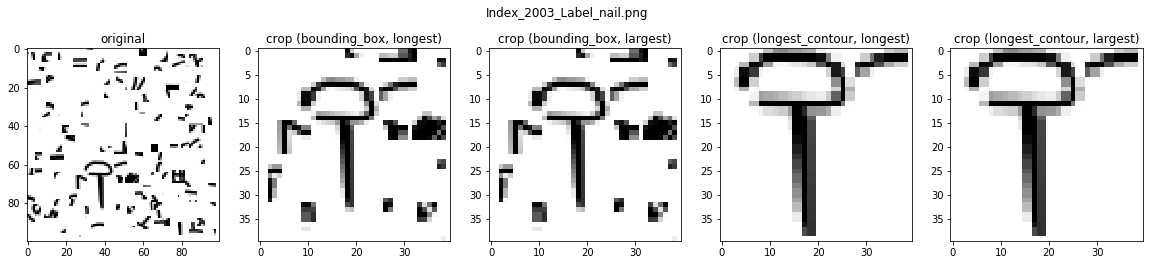

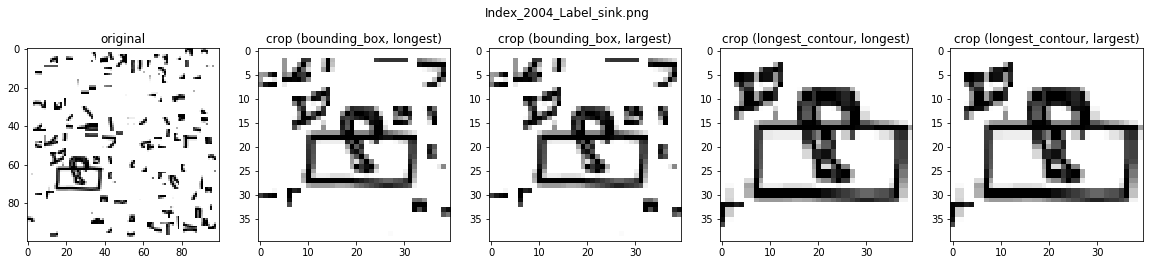

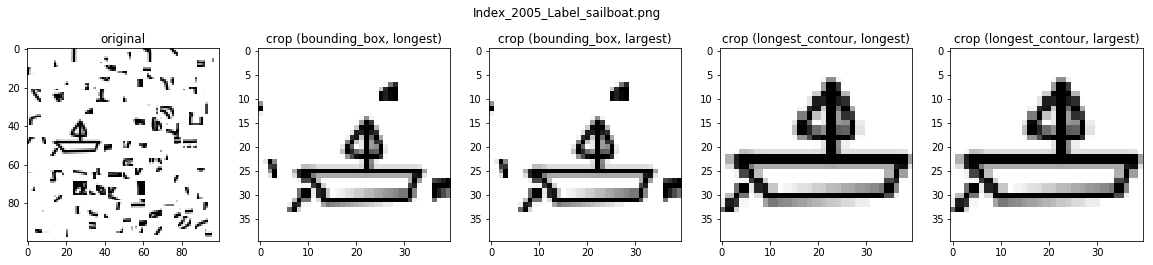

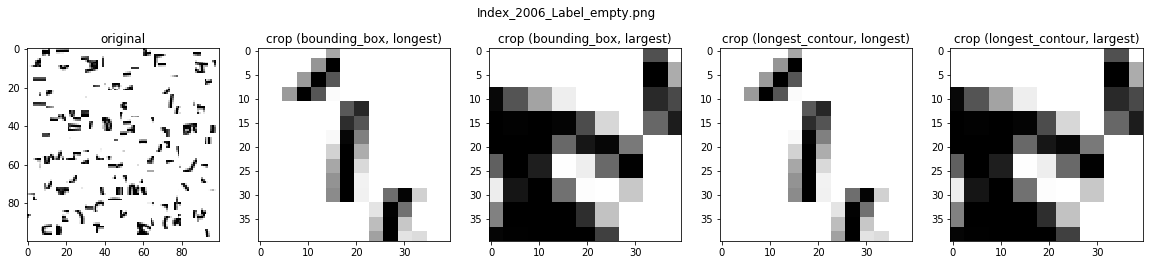

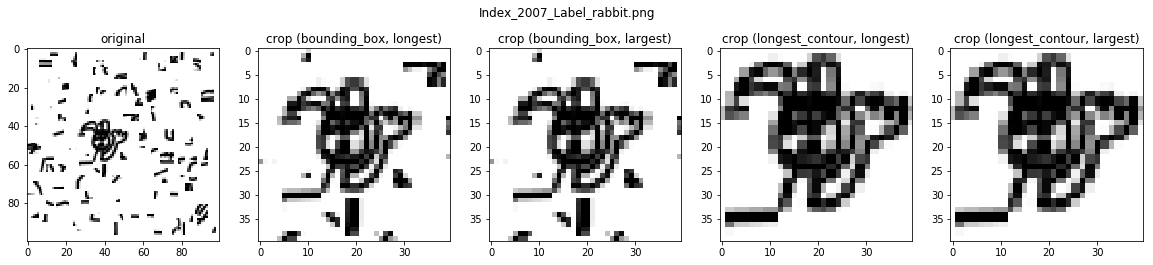

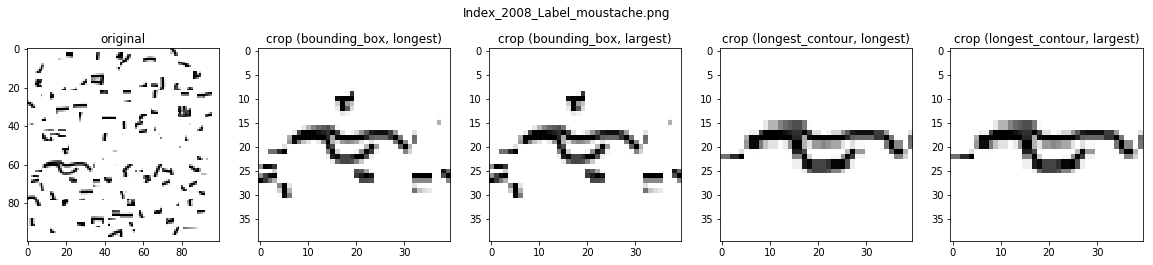

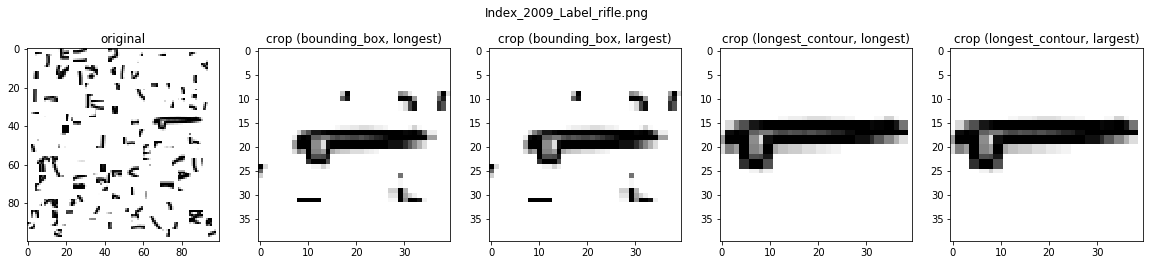

In [110]:
startI = 2000
endI = 2010
for i in range(startI, endI):
    img = images[i][1].reshape((100,100)).astype(np.uint8)
    title = "Index_" + str(i) + "_Label_" + labels.at[i,'Category'] + '.png'
    #directory = "img/"+str(startI)+"-"+str(endI - 1)
    #displayPreprocessingTestResults(img, title, directory)
    displayPreprocessingTestResults(img, title)


# Conclusions about preprocessing

It seems like the combination of doing raycasting on the contour with the largest area gives us the best results for removing noise while also keeping the image, however some failure cases are images 892, and 1133:


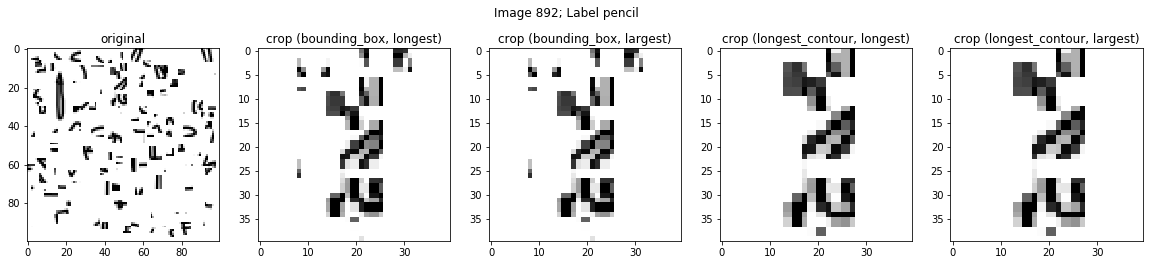

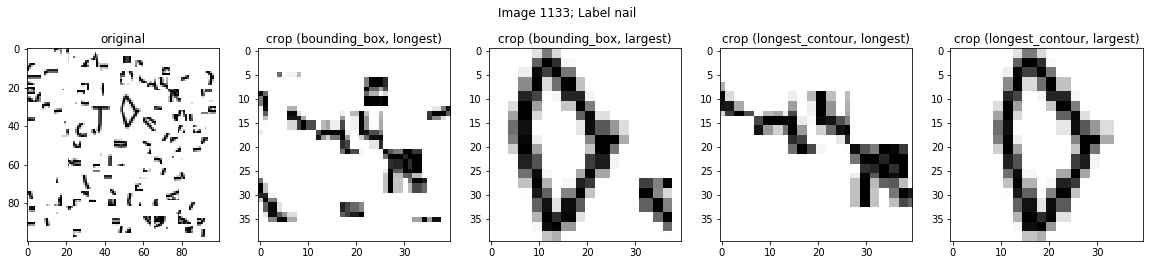

In [49]:
img_892 = images[892][1].reshape((100,100)).astype(np.uint8)
displayPreprocessingTestResults(img_892, 'Image 892; Label '+labels.at[892,'Category'])
img_1133 = images[1133][1].reshape((100,100)).astype(np.uint8)
displayPreprocessingTestResults(img_1133, 'Image 1133; Label '+labels.at[1133,'Category'])